In [1]:
import pandas as pd
import numpy as np

# matplotlib and sns plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Random Forests

Data from Lending Club to predict the state of a loan given some information about it.

Dataset [here](https://www.lendingclub.com/info/download-data.action)

2015 data.  [Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0)

In [47]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Warning about dtypes.

/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## Check Data Type

In [49]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3



## Data Cleaning

Drop variables that have the most unique types within them (especially if they're not relevant to the analysis) - for example: emp_titl, url, earliest_cr_line, revol_util.

In [50]:
# Drop columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [51]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')


In [52]:
# Drop rows with all entries as 'NAN'
y2015 = y2015.dropna(how='all')

# Drop column member ID since ID should be sufficient
y2015 = y2015.drop(columns=['member_id'])

In [53]:
# Look at the end of the file.
y2015.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421090,36371250.0,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,8 years,RENT,...,0.0,1.0,100.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,36441262.0,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,10+ years,MORTGAGE,...,0.0,2.0,56.5,100.0,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,36271333.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0


In [54]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [55]:
# List of columns
list(y2015)

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 '

## Run Random Forest Ensemble Model

y = loan_status is dependent variable
x = drop loan_status from indendent variables


Results:
- Accuracy of the cross validation scores for the tree is at about 98% accuracy.

Problems:
- No feature selection or model refinement, so a lot of unneeded features
- Inconsistencies in the accuracy scores. One score is 93% while others resulted in higher than 98%

In [11]:
# Random Forest Ensemble model
rfc = ensemble.RandomForestClassifier()

# Drop loan_status from data
X_rfc = y2015.drop('loan_status', 1)

# Set dependent variable y as loan_status
Y_rfc = y2015['loan_status']

# Create categoical variables out of non-numerical columns with get_dummies
X_rfc = pd.get_dummies(X_rfc)

# Drop all NaN 
X_rfc = X_rfc.dropna(axis=1)

# Get cross validation scores for Random Forest
cross_val_score(rfc, X_rfc, Y_rfc, cv=10)

array([0.98057515, 0.98081261, 0.98154876, 0.98176205, 0.97145571,
       0.97786749, 0.96520934, 0.98064501, 0.98016957, 0.98019285])

## DRILL: Third Attempt

- Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

- First, dive into the data that we have and see which features are most important: raw features or generated dummies. 
- Think about using PCA or correlation matrices.

- Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [12]:
# Get categories of loan_status
y2015['loan_status'].value_counts()


Current               287413
Fully Paid             87989
Charged Off            29177
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64

In [56]:
# There may be an issue with datatypes

# Get columns sorted by datatype
g_1 = y2015.columns.to_series().groupby(y2015.dtypes).groups
g_1

{dtype('float64'): Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
        'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
        'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
        'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv',
        'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_amnt', 'collections_12_mths_ex_med',
        'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint',
        'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
        'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
        'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
        'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
        'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
        'bc_open_to_buy', 'bc_util', 'c

- Will drop pymnt_plan since all entries are 'n'
- Will drop verification_status_joint since entries are related to application_type JOINT only (and application_type feature will cover it - colinearity?)


In [57]:
# payment plan column appears useless
y2015.loc[y2015['pymnt_plan'] != 'n']

# Drop pymnt_plan and verification_status_joint from y2015
y2015 = y2015.drop(columns=['pymnt_plan', 'verification_status_joint'])

In [58]:
y2015_string = y2015[['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
                     'issue_d', 'loan_status', 'purpose', 'title', 'initial_list_status',
                     'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'
                     ]]

y2015_string.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,Sep-2016,NaN,Jan-2017,INDIVIDUAL
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL
4,36 months,E,8 years,RENT,Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,May-2016,NaN,Jun-2016,INDIVIDUAL


## Run Random Forest again get_dummies of all string features (continuous features removed)

- on get_dummies of y2015_string achieve consistent scores still above 90%
- could just stop here since this rfc_2 ensemble random forest meets criteria of challenge
- since these categorical variable only represent part of data, will run pca on continuous variables to explore potential reduction in combinations of continuous and categorical data
- PCA works best with continuous variables.  On categorical variables, PCA = non-zero matrix factorization (

In [24]:
# Drop loan status and run get_dummies on y2015_string

rfc_2 = ensemble.RandomForestClassifier()

X_rfc_2 = y2015_string.drop('loan_status', 1)
Y_rfc_2 = y2015_string['loan_status']

X_rfc_2 = pd.get_dummies(X_rfc_2)
X_rfc_2 = X_rfc_2.dropna(axis=1)

cross_val_score(rfc_2, X_rfc_2, Y_rfc_2, cv=10)

array([0.92757237, 0.91686258, 0.91759873, 0.92066018, 0.89444313,
       0.90826407, 0.9064808 , 0.92778094, 0.89944665, 0.93421365])

In [27]:
# see list of dummies

y2015_dummies = pd.get_dummies(y2015_string)
list(y2015_dummies.columns)

['term_ 36 months',
 'term_ 60 months',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'home_ownership_ANY',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Not Verified',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'issue_d_Apr-2015',
 'issue_d_Aug-2015',
 'issue_d_Dec-2015',
 'issue_d_Feb-2015',
 'issue_d_Jan-2015',
 'issue_d_Jul-2015',
 'issue_d_Jun-2015',
 'issue_d_Mar-2015',
 'issue_d_May-2015',
 'issue_d_Nov-2015',
 'issue_d_Oct-2015',
 'issue_d_Sep-2015',
 'loan_status_Charged Off',
 'loan_status_Current',
 'loan_status_Default',
 'loan_status_Fully Paid',
 'loan_status_In Grace Period',
 'loan_status_Late (16-30 

## PCA on continuous features

In [60]:
# PCA: reduce dimensionality and prevent multi-colinearity - this will help to
# identify the right variables to use (can't include categorical variables - axis=1 because it's a city

# Set the variable with all continuous variables
y2015_numerical = y2015.drop(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
                     'issue_d', 'purpose', 'title', 'initial_list_status',
                     'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'
                     ], axis=1)

y2015_numerical.head()


,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,Current,33.18,0.0,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,Current,22.44,0.0,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,Fully Paid,26.02,0.0,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,Current,21.60,0.0,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,Fully Paid,25.49,0.0,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [61]:
# PCA with numerical features

# Remove dependent variable from x (independent variables)
y2015_numerical_x = y2015_numerical.drop('loan_status', 1)

# Drop NaN
y2015_numerical_x = y2015_numerical_x.dropna(axis=1)

# Normalize data
X_numerical = StandardScaler().fit_transform(y2015_numerical_x)

# Instantiate the PCA model
model_pca_numerical = PCA(n_components=5)

# Fit the model
Y_sklearn_numerical = model_pca_numerical.fit_transform(X_numerical)

# Values below are principal component values - they describe how important each axis is

# These axes are eigenvectors
# Eigenvector - is unit in x direction, is unit in y direction, is unit in z direction

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    model_pca_numerical.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.18225247 0.1069335  0.0622729  0.06010578 0.0545863 ]


In [62]:
Y_sklearn_numerical[:, 0]

array([ 3.61091543, -3.36310728,  2.41101303, ..., -2.66347418,
        0.58500006, -2.18821934])

## Get types and shapes to adjust to fit PCA components on continuous data back to categorical data to re-run Random Forest

In [68]:
# shape gets reduced from 57 to 5:
# Now we have 5 random PCA variables, but only need first two components

print('Shape of data before PCA: ', X_numerical.shape)
print('Shape of data after  PCA: ', Y_sklearn_numerical.shape)

print('Shape of Categorical Data where PCA components will be added: ', y2015_string.shape)

Shape of data before PCA:  (421093, 57)
Shape of data after  PCA:  (421093, 5)
Shape of Categorical Data where PCA components will be added:  (421093, 14)


In [67]:
# Get types
# Type of PCA components
print('Type of PCA Components: ', type(Y_sklearn_numerical))
print('Type of Categorical Variables: ',type(y2015_string))

Type of PCA Components:  <class 'numpy.ndarray'>
Type of Categorical Variables:  <class 'pandas.core.frame.DataFrame'>


In [69]:
# Make sure length matches row numbers
len(Y_sklearn_numerical[:,0])

421093

In [73]:
# create new variable that connects continuous components and catgorical data
# use .copy to avoid copy warning - but adds strain to memory - better way?
categorical_pca_combined = y2015_string.copy()

In [75]:
# First PCA Component
categorical_pca_combined['pca_1'] = Y_sklearn_numerical[:,0]

In [76]:
categorical_pca_combined.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,pca_1
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL,3.610915
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL,-3.363107
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,Sep-2016,NaN,Jan-2017,INDIVIDUAL,2.411013
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,w,Jan-2017,Jan-2017,Jan-2017,INDIVIDUAL,4.230372
4,36 months,E,8 years,RENT,Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,w,May-2016,NaN,Jun-2016,INDIVIDUAL,-0.140161


In [78]:
# Cross Validation of Random Tree with Categorical Variables and PCA component 1
# Drop loan status and run get_dummies on y2015_string with added continuous variables from PCA components 1 and 2

rfc_3 = ensemble.RandomForestClassifier()

X_rfc_3 = categorical_pca_combined.drop('loan_status', 1)
Y_rfc_3 = categorical_pca_combined['loan_status']

X_rfc_3 = pd.get_dummies(X_rfc_3, drop_first=True)
X_rfc_3 = X_rfc_3.dropna(axis=1)

cross_val_score(rfc_3, X_rfc_3, Y_rfc_3, cv=10)

array([0.89753271, 0.84533732, 0.86362233, 0.85924958, 0.81151745,
       0.85267157, 0.77482248, 0.89182578, 0.73066236, 0.5173847 ])

In [80]:
# Cross Validation of Random Tree with Categorical Variables and PCA component 1 and 2
#Add in component #2

# : = all rows; slicing 2nd component from pca component
# taking datatype = ndarray and adding new column (independent variable) to df
categorical_pca_combined['pca_2'] = Y_sklearn_numerical[:,1]

In [81]:
# Drop loan status and run get_dummies on y2015_string with added continuous variables from PCA components 1 and 2

rfc_4 = ensemble.RandomForestClassifier()

X_rfc_4 = categorical_pca_combined.drop('loan_status', 1)
Y_rfc_4 = categorical_pca_combined['loan_status']

X_rfc_4 = pd.get_dummies(X_rfc_4, drop_first=True)
X_rfc_4 = X_rfc_4.dropna(axis=1)

cross_val_score(rfc_4, X_rfc_4, Y_rfc_4, cv=10)

array([0.90228206, 0.85652205, 0.86179383, 0.86502019, 0.82199003,
       0.86326288, 0.77665107, 0.90049397, 0.71598547, 0.542678  ])

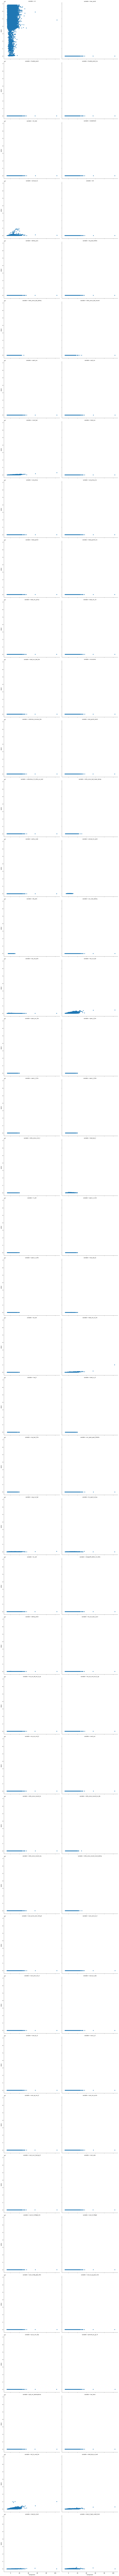

In [82]:
# Numerical data plotted to find the features in the component that are
data_to_plot_numerical = y2015_numerical.drop(['loan_status'], axis=1)
data_to_plot_numerical['Component'] = Y_sklearn_numerical[:,0]
data_to_plot_numerical = pd.melt(data_to_plot_numerical, id_vars='Component')

g_numerical = sns.FacetGrid(data_to_plot_numerical, col="variable", col_wrap=2, height=7.5, aspect=1)
g_numerical = g_numerical.map(
  sns.regplot,
  "Component",
  "value",
  x_jitter=.49,
  y_jitter=.49,
  fit_reg=False
)

plt.show()

## The numerical features that appear to have the most variance responsible for the outcome
total_il_high_credit_limit
tot_hi_cred_lim
total_rev_hi_lim
tot_cur_bal
revol_bal
annual_inc
total_il_high_credit_limit
total_rev_hi_lim

In [277]:
# Rerun ensemble model with numerical features identified by PCA

y2015_numerical_features = y2015[['total_il_high_credit_limit', 'tot_hi_cred_lim', 'total_rev_hi_lim',
                                  'tot_cur_bal', 'revol_bal', 'annual_inc', 'total_il_high_credit_limit',
                                  'total_rev_hi_lim' 
                     ]]

# Drop loan status from x
rfc_numerical_features = ensemble.RandomForestClassifier()
X_rfc_numerical_features = y2015_numerical_features
Y_rfc_numerical_features = y2015['loan_status']
X_rfc_numerical_features = pd.get_dummies(X_rfc_numerical_features)
X_rfc_numerical_features = X_rfc_numerical_features.dropna(axis=1)

cross_val_score(rfc_numerical_features, X_rfc_numerical_features, Y_rfc_numerical_features, cv=10)


array([0.64793047, 0.64999644, 0.64913322, 0.64806459, 0.64991688,
       0.64979815, 0.65208511, 0.64811912, 0.64853825, 0.64855365])

In [ ]:
# Combine PCA identified continuous variables with categorical variables
# A matrix transform that reduces dimenisionality
# PCA identifies variables that make up vector whose coordinate system is fine tuned to data: if there's variance
# in a particular random variable, identify axis that captures it so whne you get new data it's largely spread around
# a particular axis.

# PCA decomposes data into projecting it onto axes that are going to get most "action" - explain variance?
# Then we can focus on the variable that's having the greatest impact.

# Vector: can be n-dimensional (in this case 8)

# Orthogonal: No correlation between the data.  When you have more than 3 dimensions there will be corrlation.

# Projection: 

# Columns = random variables, unlike a function that produces a y given an x
# Row = sample

# Each element of the column is an observation
# From sample data, infer real statistics of random variable

# 8 random variables - we've sampled population and we get some insight on the population based on whole row:
    # total_il_high_credit_limit
    # tot_hi_cred_lim
    # total_rev_hi_lim
    # tot_cur_bal
    # revol_bal
    # annual_inc
    # total_il_high_credit_limit
    # total_rev_hi_lim

# The trick is to understand what correlation there is between samples (an entire row)
# A sample has multiple attributes, and each attribute corresponds to a random variable

# How correlated is the variance between one random variable 

# Projection is a way to decompose - shining a flash light in the number of directions you specify:
# (pca components set): PCA(n_components=5)
# Decomposing - done for each row (sample)
# (x,y) (3,2)
# Decomposing - think about what's projected onto x axis (or any axis) - in this case for x axis, 3
# Decomposing - and y (in this case) gets a 0. So, decomposed = (3,0)
    

## Conclusion

Best performing Random Forest is first one completed: categorical variables only.